In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
from datetime import datetime, date
import json
from xgrads import open_CtlDataset
import geopandas as gpd
import requests
import hydrofunctions as hf
import matplotlib.pyplot as plt
import folium 
%matplotlib inline

In [2]:
# Choose a domain
domain = 'CHUK'

# calibration dates
# start calibration date    
st_dtcal = '2013-10-01'
# end calibration date
ed_dtcal = '2014-09-30'

# paths 
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'
# data location
datapath = '/nfs/attic/dfh/2020_NPRB/data/'
# stream gauge data
flowpath = datapath+'stream_gage/'+domain+'/'
# calibration disgharge data
flowdatacal = flowpath+domain+'_discharge_cfs_'+st_dtcal+'_'+ed_dtcal+'.csv'
# calibration station gdf
flowstncal = flowpath+domain+'_gage_meta_'+st_dtcal+'_'+ed_dtcal+'.geojson'
# calibration station gdf projected
flowstnprojcal = flowpath+domain+'_gage_meta_proj_'+st_dtcal+'_'+ed_dtcal+'.geojson'

#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

In [3]:
stnproj = gpd.read_file(flowstnprojcal)

This notebook requires manual examination of each station to retrieve the i, j pair from the hydroflow data. Manual corrections are often required to match the station location to the stream channel that was determined in hydroflow. 

# find i j pair for each station 

Need to find the i j pair for each of the gage locations to extract hydroflow output. To do this - each station locaiton needs to be compared to the disgarge output to make sure it align with the computed river network. 

In [4]:
#use topo to get spatial info
# SM forcing files 
SMdatapath = datapath+'SMinputs/'+domain+'/'
# dem ascii file
demasc = SMdatapath+domain+'_dem.asc'

topo = rxr.open_rasterio(demasc)

In [6]:
#hydroflow discharge data using pixel centers 
ctlFile = SMpath+'outputs/wo_assim/disc_base.ctl'

q = open_CtlDataset(ctlFile)
q=q.assign_coords({"lat": np.flipud(topo.y.values)-int(domains[domain]['cellsize']),"lon": topo.x.values-int(domains[domain]['cellsize'])})

q

,Array,Chunk
Bytes,5.80 GiB,2.32 MiB
Shape,"(2557, 1, 798, 763)","(1, 1, 798, 763)"
Count,2557 Tasks,2557 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.80 GiB,2.32 MiB
Shape,"(2557, 1, 798, 763)","(1, 1, 798, 763)"
Count,2557 Tasks,2557 Chunks
Type,float32,numpy.ndarray


In [7]:
# domain shapefile
shp = gpd.read_file('/nfs/attic/dfh/2020_NPRB/data/gis/'+domain+'/'+domain+'.json')
shpproj = shp.to_crs(stnproj.crs)

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

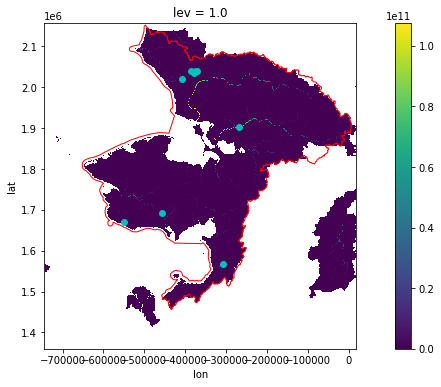

In [8]:
qsum = q.slow.isel(lev=0).sum('time')+q.fast.isel(lev=0).sum('time')

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
shpproj.plot(ax=ax,facecolor='None',edgecolor='r')

In [9]:
# Add custom base maps to folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}

In [10]:
stnproj

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,xidx,yidx,geometry
0,USGS,15565700,UNALAKLEET R AB CHIROSKEY R NR UNALAKLEET AK,ST,635606.0,1601818.0,63.934297,-160.307472,M,S,...,None,None,None,None,None,None,None,436,201,POINT (-308388.091 1566798.002)
1,USGS,15580095,NIUKLUK R AB MELSING C AT COUNCIL AK,ST,645331.0,1634012.0,64.891944,-163.670000,N,S,...,None,None,None,None,None,None,None,288,331,POINT (-456325.261 1692287.300)
2,USGS,15621000,SNAKE R NR NOME AK,ST,643351.0,1653026.0,64.563397,-165.509808,M,U,...,None,None,None,None,None,None,None,196,310,POINT (-548664.359 1670023.966)
3,USGS,15744500,KOBUK R NR KIANA AK,ST,665825.0,1600751.0,66.972994,-160.133631,M,T,...,None,None,None,None,None,None,None,476,542,POINT (-268698.713 1903009.388)
4,USGS,15746900,WULIK R AB FERRIC C NR KIVALINA AK,ST,680442.0,1631115.0,68.077675,-163.190455,M,T,...,None,None,None,None,None,None,None,359,678,POINT (-385009.770 2039698.999)
5,USGS,15746980,IKALUKROK C AB RED DOG C NR KIVALINA AK,ST,680538.0,1625647.0,68.093236,-162.949346,M,U,...,None,None,None,None,None,None,None,370,680,POINT (-374739.933 2040025.119)
6,USGS,15746988,NF RED DOG C NR KIVALINA AK,ST,680503.0,1625252.0,68.083515,-162.884066,M,U,...,None,None,None,None,None,None,None,371,677,POINT (-372166.259 2038592.412)
7,USGS,15746990,RED DOG C AB MOUTH NR KIVALINA AK,ST,680522.0,1625622.0,68.088791,-162.942401,G,S,...,None,None,None,None,None,None,None,370,678,POINT (-374516.875 2039498.785)
8,USGS,15746991,IKALUKROK C BL RED DOG C NR KIVALINA AK,ST,680251.0,1630134.0,68.046845,-163.029062,M,T,...,None,None,None,None,None,None,None,365,675,POINT (-378752.998 2035392.305)
9,USGS,15747000,WULIK R BL TUTAK C NR KIVALINA AK,ST,675234.0,1634028.0,67.875440,-163.677373,M,T,...,None,None,None,None,None,None,None,334,659,POINT (-408516.582 2020453.978)


In [11]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

# 15565700

In [12]:
i=0
stnproj.site_no[i]

'15565700'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

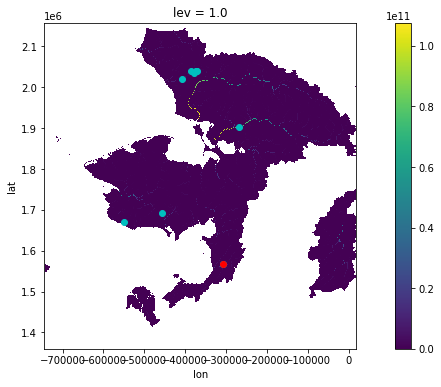

In [13]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15565700


(-316500.0, -300500.0)

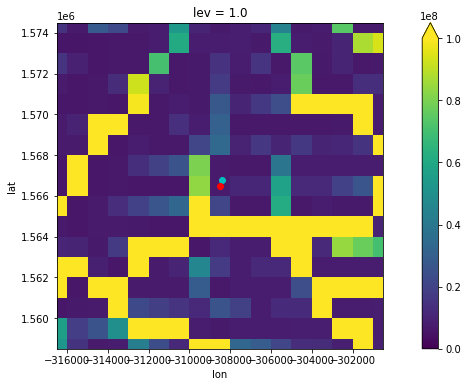

In [14]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [15]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)


yidx =  206
xidx =  436


(-316500.0, -300500.0)

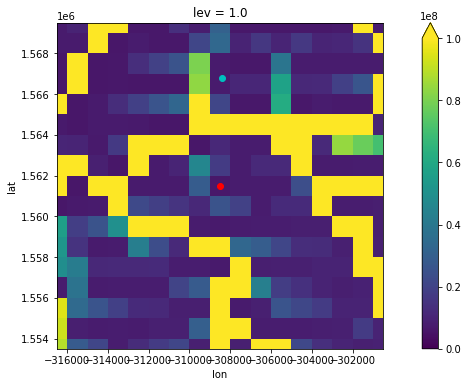

In [16]:
yidx = int(np.where(q.lat == slow.lat)[0]-5)
xidx = int(np.where(q.lon == slow.lon)[0])
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [17]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  201
xidx fixed =  436


In [18]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [19]:
#indicies to save out
xidx1 = xidx
yidx1 = yidx

# 15580095

In [20]:
i=1
stnproj.site_no[i]

'15580095'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

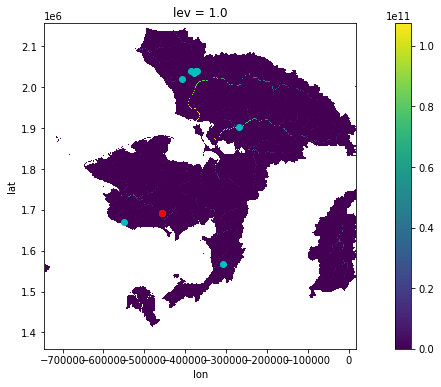

In [21]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15580095


(-468500.0, -444500.0)

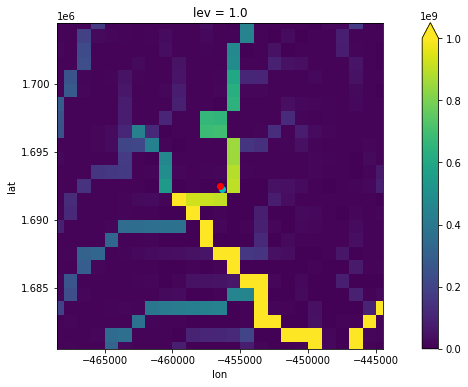

In [22]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-12000,dftest.y.values[0]+12000])
plt.xlim([dftest.x.values[0]-12000,dftest.x.values[0]+12000])

In [23]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  332
xidx =  288


(-466500.0, -450500.0)

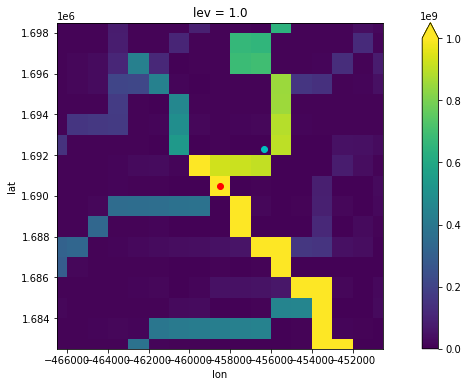

In [24]:
yidx = int(np.where(q.lat == slow.lat)[0]-2)
xidx = int(np.where(q.lon == slow.lon)[0]-2)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [25]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  330
xidx fixed =  286


In [26]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [27]:
#indicies to save out
xidx2 = xidx
yidx2 = yidx

# 15621000

In [28]:
i=2
stnproj.site_no[i]

'15621000'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

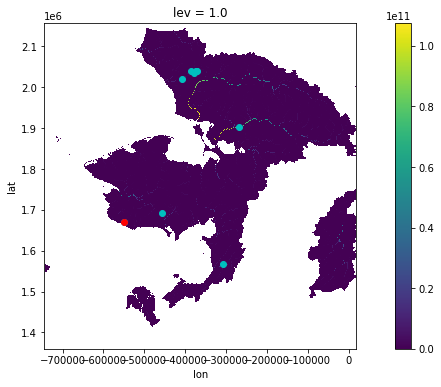

In [29]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15621000


(-551500.0, -545500.0)

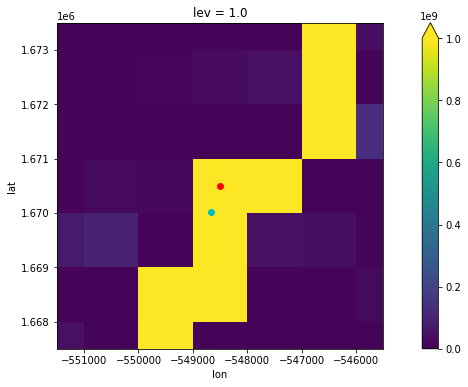

In [30]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-3000,dftest.y.values[0]+3000])
plt.xlim([dftest.x.values[0]-3000,dftest.x.values[0]+3000])

In [31]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  310
xidx =  196


In [32]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [33]:
#indicies to save out
xidx3 = xidx
yidx3 = yidx

# 15744500

In [34]:
i=3
stnproj.site_no[i]

'15744500'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

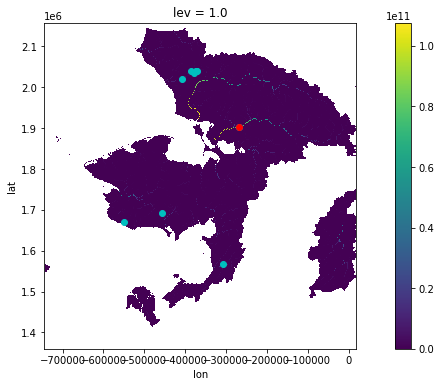

In [35]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15744500


(-273500.0, -263500.0)

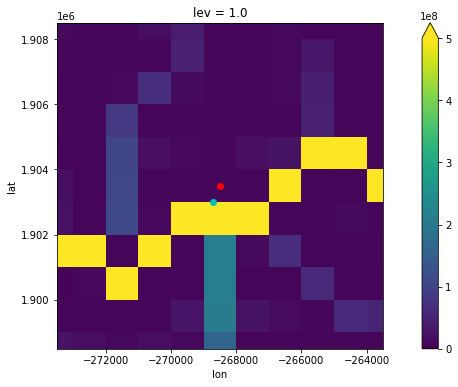

In [36]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=5e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-5000,dftest.y.values[0]+5000])
plt.xlim([dftest.x.values[0]-5000,dftest.x.values[0]+5000])

In [37]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  543
xidx =  476


Note: need to move the lat down by two pixels to land in the modeled channel 

(-273500.0, -258500.0)

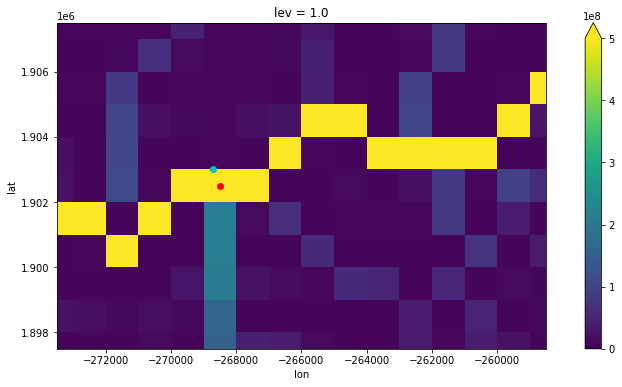

In [38]:
yidx = int(np.where(q.lat == slow.lat)[0]-1)
xidx = int(np.where(q.lon == slow.lon)[0])
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=5e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-5000,dftest.y.values[0]+5000])
plt.xlim([dftest.x.values[0]-5000,dftest.x.values[0]+10000])

In [39]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  542
xidx fixed =  476


In [40]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [41]:
#indicies to save out
xidx4 = xidx
yidx4 = yidx

# 15746900

In [42]:
i=4
stnproj.site_no[i]

'15746900'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

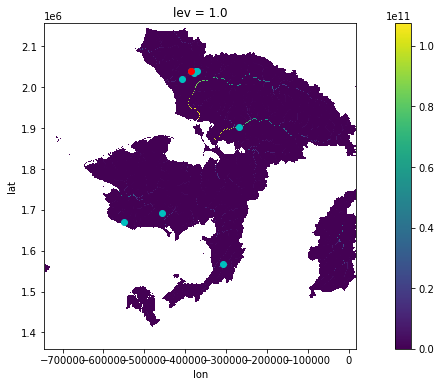

In [43]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15746900


(-388500.0, -382500.0)

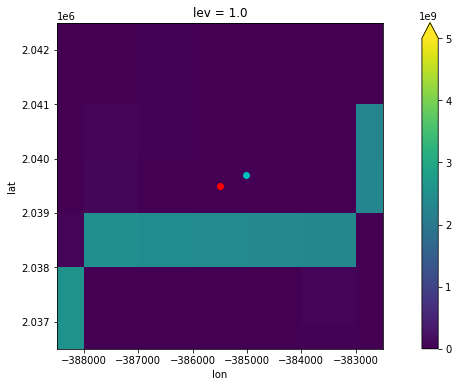

In [44]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=5e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-3000,dftest.y.values[0]+3000])
plt.xlim([dftest.x.values[0]-3000,dftest.x.values[0]+3000])

In [45]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  679
xidx =  359


(-390500.0, -380500.0)

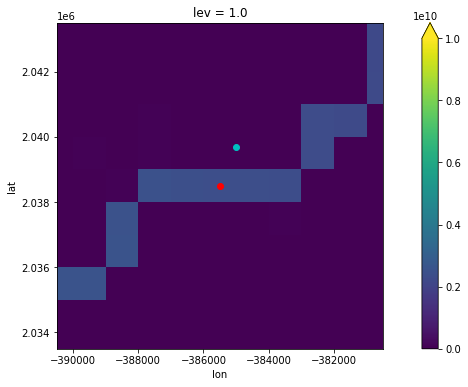

In [46]:
yidx = int(np.where(q.lat == slow.lat)[0]-1)
xidx = int(np.where(q.lon == slow.lon)[0])
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e10,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-5000,dftest.y.values[0]+5000])
plt.xlim([dftest.x.values[0]-5000,dftest.x.values[0]+5000])

In [47]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  678
xidx fixed =  359


In [48]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [49]:
#indicies to save out
xidx5 = xidx
yidx5 = yidx

# 15746980

In [50]:
i=5
stnproj.site_no[i]

'15746980'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

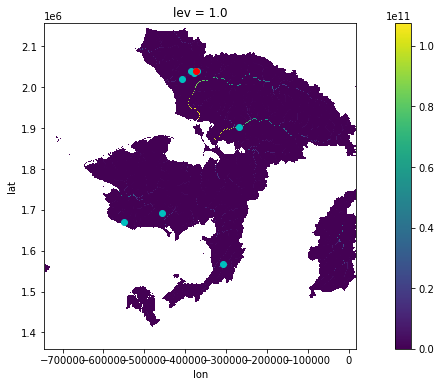

In [51]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15746980


(-379500.0, -369500.0)

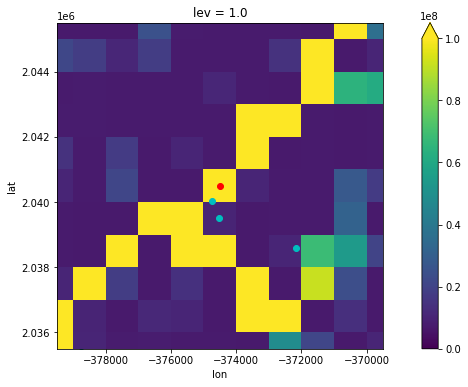

In [52]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-5000,dftest.y.values[0]+5000])
plt.xlim([dftest.x.values[0]-5000,dftest.x.values[0]+5000])

In [53]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  680
xidx =  370


In [54]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [55]:
#indicies to save out
xidx6 = xidx
yidx6 = yidx

# 15746988

In [56]:
i=6
stnproj.site_no[i]

'15746988'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

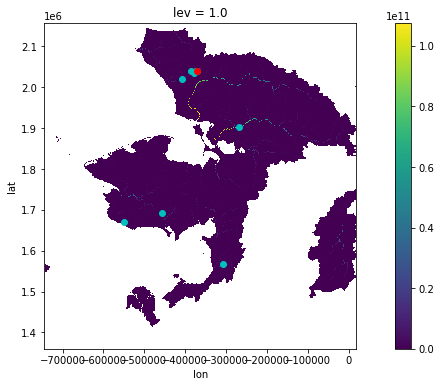

In [57]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15746988


(-380500.0, -364500.0)

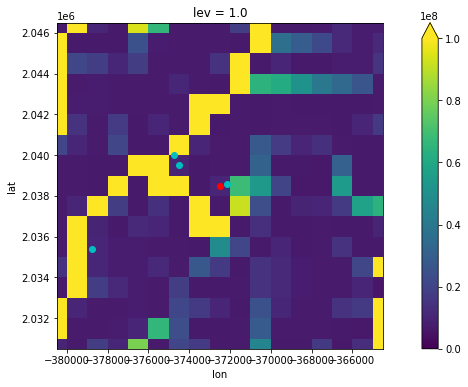

In [58]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [59]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  678
xidx =  372


(-381500.0, -365500.0)

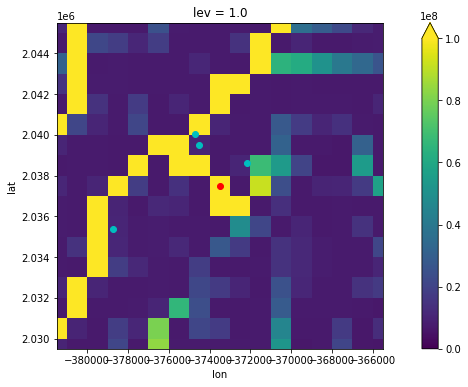

In [60]:
yidx = int(np.where(q.lat == slow.lat)[0]-1)
xidx = int(np.where(q.lon == slow.lon)[0]-1)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [61]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  677
xidx fixed =  371


In [62]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [63]:
#indicies to save out
xidx7 = xidx
yidx7 = yidx

# 15746990

In [64]:
i=7
stnproj.site_no[i]

'15746990'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

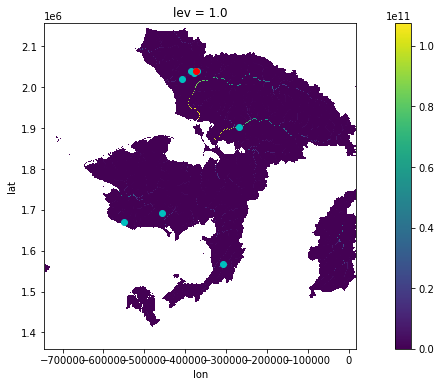

In [65]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15746990


(-377500.0, -371500.0)

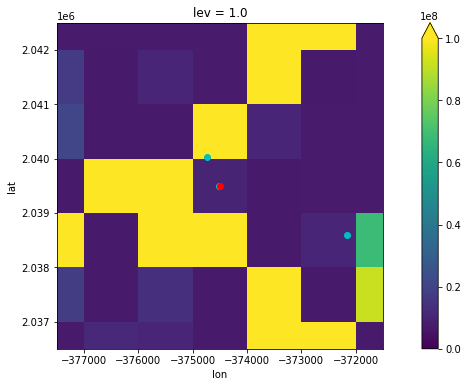

In [66]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-3000,dftest.y.values[0]+3000])
plt.xlim([dftest.x.values[0]-3000,dftest.x.values[0]+3000])

In [67]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  679
xidx =  370


Note: need to move the lat down by one pixel to reside in the modeled channel 

(-382500.0, -366500.0)

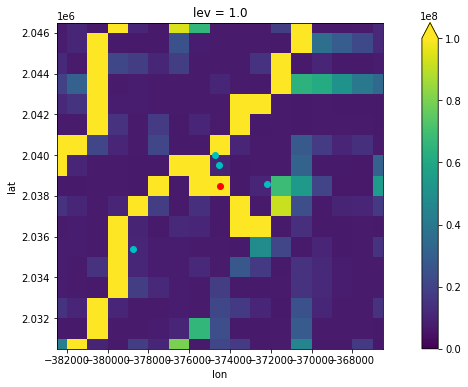

In [68]:
yidx = int(np.where(q.lat == slow.lat)[0]-1)
xidx = int(np.where(q.lon == slow.lon)[0])
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e8,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-8000,dftest.y.values[0]+8000])
plt.xlim([dftest.x.values[0]-8000,dftest.x.values[0]+8000])

In [69]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  678
xidx fixed =  370


In [70]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [71]:
#indicies to save out
xidx8 = xidx
yidx8 = yidx

# 15746991

In [72]:
i=8
stnproj.site_no[i]

'15746991'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

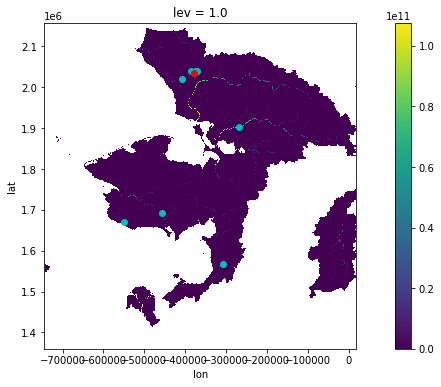

In [73]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15746991


(-381500.0, -375500.0)

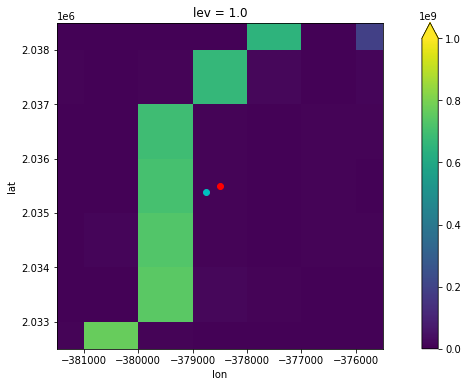

In [74]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-3000,dftest.y.values[0]+3000])
plt.xlim([dftest.x.values[0]-3000,dftest.x.values[0]+3000])

In [75]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  675
xidx =  366


Note: need to move the lon to the left by 1 pixel to reside in the modeled channel 

(-382500.0, -376500.0)

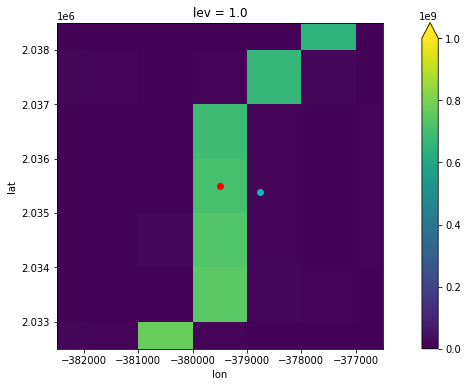

In [76]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0]-1)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-3000,dftest.y.values[0]+3000])
plt.xlim([dftest.x.values[0]-3000,dftest.x.values[0]+3000])

In [77]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  675
xidx fixed =  365


In [78]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [79]:
#indicies to save out
xidx9 = xidx
yidx9 = yidx

# 15747000

In [88]:
i=9
stnproj.site_no[i]

'15747000'

<Axes: title={'center': 'lev = 1.0'}, xlabel='lon', ylabel='lat'>

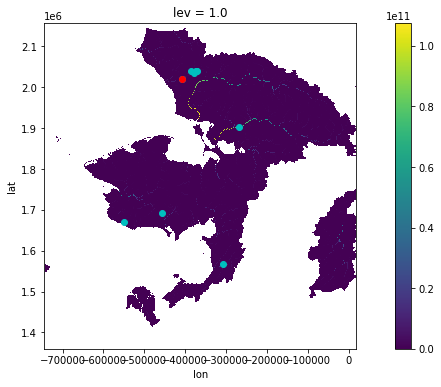

In [89]:
fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,ax=ax)
stnproj.plot(ax=ax,c='c')
stnproj.where(stnproj.site_no == stnproj.site_no[i]).plot(ax=ax,c='r')

Station # = 15747000


(-418500.0, -398500.0)

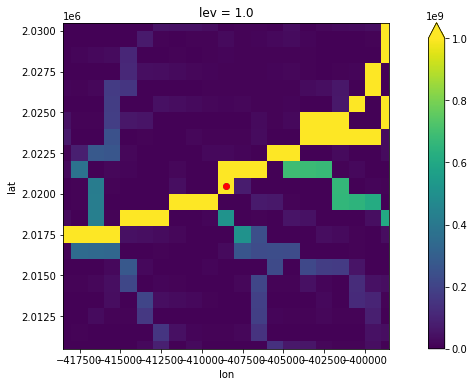

In [90]:
print('Station # = '+ stnproj.iloc[i].site_no)
slow = q.slow.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
fast = q.fast.sel(lon=stnproj.iloc[i].geometry.x, lat=stnproj.iloc[i].geometry.y, lev=1.0,method='nearest')
# dataframe 
dftest = pd.DataFrame({'x':[slow.lon.values.tolist()], 'y':[slow.lat.values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-10000,dftest.y.values[0]+10000])
plt.xlim([dftest.x.values[0]-10000,dftest.x.values[0]+10000])

In [91]:
yidx = int(np.where(q.lat == slow.lat)[0])
xidx = int(np.where(q.lon == slow.lon)[0])
print('yidx = ', yidx)
print('xidx = ', xidx)

yidx =  660
xidx =  336


Note: need to move the lon to the left by two pixel to land in the modeled channel 

(-411500.0, -391500.0)

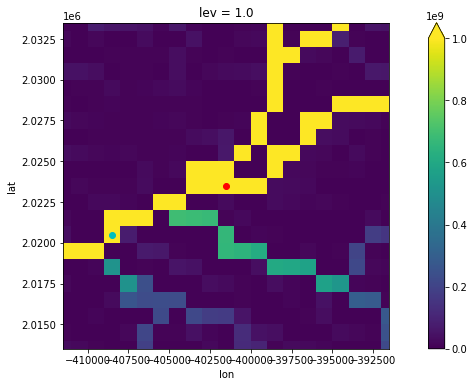

In [84]:
yidx = int(np.where(q.lat == slow.lat)[0]+3)
xidx = int(np.where(q.lon == slow.lon)[0]+7)
# dataframe 
dftest = pd.DataFrame({'x':[q.lon.isel(lon=xidx).values.tolist()], 'y':[q.lat.isel(lat=yidx).values.tolist()]})
# geodataframe
gdftest = gpd.GeoDataFrame(dftest,geometry=gpd.points_from_xy(dftest.x, dftest.y),crs=domains[domain]['mod_proj'])

fig, ax = plt.subplots(figsize=(14,6))

qsum.where(qsum>0).plot(vmin=0,vmax=1e9,ax=ax)
stnproj.plot(ax=ax,c='c')
gdftest.plot(ax=ax,c='r')
#gdftest2.plot(ax=ax,c='g')
plt.ylim([dftest.y.values[0]-10000,dftest.y.values[0]+10000])
plt.xlim([dftest.x.values[0]-10000,dftest.x.values[0]+10000])

In [85]:
print('yidx fixed = ', yidx)
print('xidx fixed = ', xidx)

yidx fixed =  663
xidx fixed =  343


In [86]:
m = folium.Map(tiles='Stamen terrain')
for idx, row in stnproj.iterrows():
    folium.Marker(location=[row['dec_lat_va'], row['dec_long_va']], 
                  icon=folium.Icon(color='blue'),
                  popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                      row['site_no'], row['station_nm'])
                 ).add_to(m)
folium.Marker(location=[gdftest.to_crs('epsg:4326').geometry.y.values[0], gdftest.to_crs('epsg:4326').geometry.x.values[0]], 
              icon=folium.Icon(color='red'),
              popup="</br> Gage#: {0} </b> Gage name: {1}".format(
                  row['site_no'], row['station_nm'])
             ).add_to(m)

# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

basemaps['Google Satellite'].add_to(m)

m

In [92]:
#indicies to save out
xidx10 = xidx
yidx10 = yidx

## save data

In [93]:
# from anaylsis above
xidx = [xidx1,xidx2,xidx3,xidx4,xidx5,xidx6,xidx7,xidx8,xidx9,xidx10]
yidx = [yidx1,yidx2,yidx3,yidx4,yidx5,yidx6,yidx7,yidx8,yidx9,yidx10]

In [96]:
# add x and y idx to metadata
stnproj['xidx'] = xidx
stnproj['yidx'] = yidx
path=flowstnprojcal
stnproj.to_file(path, driver='GeoJSON') 

/nfs/attic/dfh/miniconda/envs/nprb/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [97]:
stnproj

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,xidx,yidx,geometry
0,USGS,15565700,UNALAKLEET R AB CHIROSKEY R NR UNALAKLEET AK,ST,635606.0,1601818.0,63.934297,-160.307472,M,S,...,None,None,None,None,None,None,None,436,201,POINT (-308388.091 1566798.002)
1,USGS,15580095,NIUKLUK R AB MELSING C AT COUNCIL AK,ST,645331.0,1634012.0,64.891944,-163.670000,N,S,...,None,None,None,None,None,None,None,286,330,POINT (-456325.261 1692287.300)
2,USGS,15621000,SNAKE R NR NOME AK,ST,643351.0,1653026.0,64.563397,-165.509808,M,U,...,None,None,None,None,None,None,None,196,310,POINT (-548664.359 1670023.966)
3,USGS,15744500,KOBUK R NR KIANA AK,ST,665825.0,1600751.0,66.972994,-160.133631,M,T,...,None,None,None,None,None,None,None,476,542,POINT (-268698.713 1903009.388)
4,USGS,15746900,WULIK R AB FERRIC C NR KIVALINA AK,ST,680442.0,1631115.0,68.077675,-163.190455,M,T,...,None,None,None,None,None,None,None,359,678,POINT (-385009.770 2039698.999)
5,USGS,15746980,IKALUKROK C AB RED DOG C NR KIVALINA AK,ST,680538.0,1625647.0,68.093236,-162.949346,M,U,...,None,None,None,None,None,None,None,370,680,POINT (-374739.933 2040025.119)
6,USGS,15746988,NF RED DOG C NR KIVALINA AK,ST,680503.0,1625252.0,68.083515,-162.884066,M,U,...,None,None,None,None,None,None,None,371,677,POINT (-372166.259 2038592.412)
7,USGS,15746990,RED DOG C AB MOUTH NR KIVALINA AK,ST,680522.0,1625622.0,68.088791,-162.942401,G,S,...,None,None,None,None,None,None,None,370,678,POINT (-374516.875 2039498.785)
8,USGS,15746991,IKALUKROK C BL RED DOG C NR KIVALINA AK,ST,680251.0,1630134.0,68.046845,-163.029062,M,T,...,None,None,None,None,None,None,None,365,675,POINT (-378752.998 2035392.305)
9,USGS,15747000,WULIK R BL TUTAK C NR KIVALINA AK,ST,675234.0,1634028.0,67.875440,-163.677373,M,T,...,None,None,None,None,None,None,None,336,660,POINT (-408516.582 2020453.978)
